In [1]:
# Imports:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.metrics import mean_squared_error
import plotly.express as px
from scipy import stats


In [2]:
#set seed for reproducibility
random_state = 42
np.random.seed(random_state)

In [3]:
with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_1_period_dataset_dict.pickle', 'rb') as f:
    us_data_dict = pickle.load(f)

In [4]:
us_data = pd.read_csv(r'/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/resources/hrnn_cpi_dataset.csv')

In [5]:
us_data.head()

,Date,Category,Category_id,Price,Weight,Indent,Parent,Parent_ID
0,1984-01-15,All items,8106.0,101.9,100.0,0.0,NaN,NaN
1,1984-02-15,All items,8106.0,102.4,100.0,0.0,NaN,NaN
2,1984-03-15,All items,8106.0,102.6,100.0,0.0,NaN,NaN
3,1984-04-15,All items,8106.0,103.1,100.0,0.0,NaN,NaN
4,1984-05-15,All items,8106.0,103.4,100.0,0.0,NaN,NaN


In [6]:
us_data.groupby('Indent').Price.describe(percentiles = [0.05,0.1,0.25,0.5,0.75,0.9,0.95]).round(2)

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
Indent,,,,,,,,,,,,
0.0,477.0,189.52,52.84,101.90,108.88,115.58,145.80,185.00,233.89,256.22,274.66,307.48
1.0,8106.0,209.12,78.92,98.80,111.80,120.92,149.30,204.96,242.02,302.52,367.15,557.43
2.0,7152.0,188.89,64.21,72.75,85.04,103.75,144.30,183.00,231.81,273.96,307.72,423.74
3.0,6501.0,179.54,80.51,7.09,70.58,88.20,120.20,171.28,230.12,286.91,321.82,508.91
4.0,9815.0,203.31,161.32,32.80,57.16,81.31,116.29,151.10,233.48,351.27,488.08,1443.71
5.0,17766.0,189.11,135.27,1.10,34.57,67.92,106.71,157.15,228.67,345.47,461.14,1041.74
6.0,10677.0,245.31,136.97,36.41,85.02,109.40,162.48,223.64,302.95,370.10,464.00,995.84
7.0,5004.0,215.14,91.90,31.12,65.98,127.81,152.13,199.06,270.95,325.97,367.56,618.72
8.0,987.0,246.57,57.92,132.09,144.15,154.05,216.72,241.54,292.88,317.81,345.78,395.30


In [7]:
us_data.groupby('Indent').Category_id.nunique().reset_index()

,Indent,Category_id
0,0.0,1
1,1.0,26
2,2.0,24
3,3.0,25
4,4.0,48
5,5.0,110
6,6.0,73
7,7.0,36
8,8.0,7


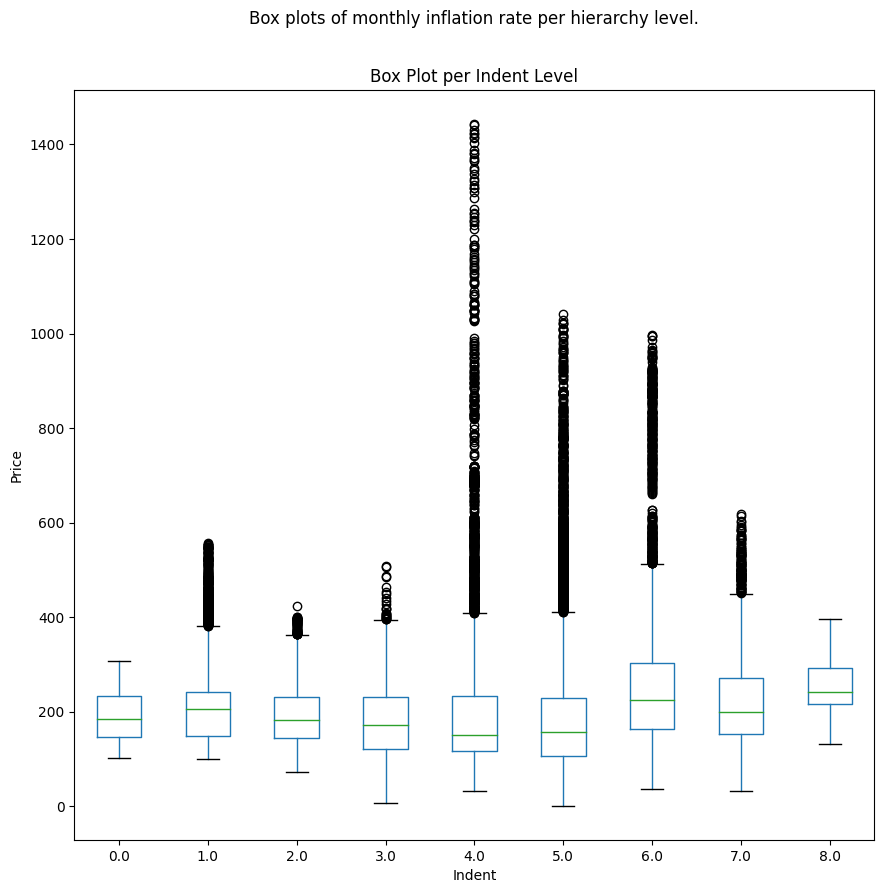

In [8]:
# Create box plots for each indent level
us_data.boxplot(column='Price', by='Indent', grid=False, figsize=(10,10))
plt.title('Box Plot per Indent Level')
plt.xlabel('Indent')
plt.ylabel('Price')
plt.suptitle('Box plots of monthly inflation rate per hierarchy level.') 
plt.show()

--------

### Horizon Analyses:

In [9]:
# import horizon files 
with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1_period/data/hor1_test_dataset.pickle', 'rb') as f:
    us_hor_1_test_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1_period/data/hor2_test_dataset.pickle', 'rb') as f:
    us_hor_2_test_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1_period/data/hor3_test_dataset.pickle', 'rb') as f:
    us_hor_3_test_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1_period/data/hor4_test_dataset.pickle', 'rb') as f:
    us_hor_4_test_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1_period/data/hor8_test_dataset.pickle', 'rb') as f:
    us_hor_8_test_dict = pickle.load(f)

In [10]:
import sys        
sys.path.append('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1_period')       
import model
from model.GRU_model import *
from pipeline_config import *
from model.config import * 
from model.utils import *
Lr = 0.056545778817006995

2023-11-14 16:37:18.930327: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
num_forecast_steps = 8

category_horizon_dict = {}

for category_name in list(us_hor_1_test_dict.keys()):
    # load model
    cat_model = GRUModel(input_dim=Features, hidden_dim=HiddenSize, layer_dim=LayersDim, output_dim=OutputDim, dropout_prob=DropoutProb)
    cat_optimizer = torch.optim.AdamW(cat_model.parameters(), lr=Lr)
    cat_model.to(Device)

    category_model, optimizer, checkpoint, valid_loss_min = load_checkpoint('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1_period/models_weights/'+category_name+'.pt', cat_model, cat_optimizer)

    horizon_dict = {}

    # Generate forecasts step by step
    for step in range(num_forecast_steps):
        with torch.no_grad():
            # create dataloader
            x_test = us_hor_1_test_dict[category_name].iloc[:,:-1].to_numpy()
            y_test= us_hor_1_test_dict[category_name].iloc[:,-1:].to_numpy()

            x_test = torch.from_numpy(x_test).to(torch.float32)
            y_test = torch.from_numpy(y_test).to(torch.float32)

            test_dataset = TensorDataset(x_test, y_test)

            test_dataloader =  DataLoader(test_dataset, batch_size=33, shuffle=False) #### NOTE: I had to fix the batch size to 33 because of size mismatch issues (input was larger than batch size and it caused issues - so it is 33 rather than 32 like the rest (canada and norway datasets))

            for inputs, labels in test_dataloader:
                # since each batch contains 32 samples, and the largest df is of size 32, then we dont need to concat the outputs per batch per category.
                inputs = inputs.view(inputs.shape[0], SequenceLength, Features)
                #print(f'inputs shape: {inputs.shape}')
                #print(f'labels shape: {labels.shape}')
                inputs, labels = inputs.to(Device), labels.to(Device)
                out = category_model(inputs)
                out_df = pd.DataFrame(out)
                
                first = us_hor_1_test_dict[category_name].iloc[:,1:].reset_index(drop = True).copy()
                print(f'first shape: {first.shape}')
                second = out_df.reset_index(drop = True).rename(columns = {0: 'Inflation t+'+str(2+step)})
                print(f'second shape: {second.shape}')

                us_hor_1_test_dict[category_name] = pd.concat([first, second],axis=1) #prediction

                horizon_dict[step+2] = us_hor_1_test_dict[category_name]

    category_horizon_dict[category_name] = horizon_dict
    


first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second shape: (33, 1)
first shape: (33, 13)
second sha

In [12]:
def avg_rmse_hor(prediction_dict, actual_dict, horizon):
    mse_lst = []
    for key in list(actual_dict.keys()):
        predictions = prediction_dict[key][horizon].iloc[:,-1:].reset_index(drop = True)
        actuals = actual_dict[key].iloc[:,-1:].reset_index(drop = True)

        y_pred = predictions.values
        y_actual = actuals.values

        non_null_indices = ~np.isnan(y_pred) & ~np.isnan(y_actual)

        predicted_values_non_null = y_pred[non_null_indices]
        observed_values_non_null = y_actual[non_null_indices]

        #print(f'y pred: {predicted_values_non_null}')
        #print(f'y actual: {observed_values_non_null}')
        mse = mean_squared_error(predicted_values_non_null, observed_values_non_null)
        mse_lst.append(mse)
    
    rmse_list = list(map(np.sqrt,mse_lst))
    avg_rmse = np.mean(rmse_list)
    rmse_std = np.std(rmse_list)
    
    print(f'RMSE:  {avg_rmse}')
    print(f'MSE std:  {rmse_std}')
    print(f'interval: {[avg_rmse-rmse_std, avg_rmse+rmse_std]}')

    return avg_rmse,rmse_std

In [13]:
avg_rmse_hor(category_horizon_dict, us_hor_2_test_dict, 2)

RMSE:  1.40209755216622
MSE std:  1.2399601745869733
interval: [0.16213737757924673, 2.642057726753193]


(1.40209755216622, 1.2399601745869733)

In [14]:
avg_rmse_hor(category_horizon_dict, us_hor_3_test_dict, 3)

RMSE:  1.4189184616210657
MSE std:  1.2342761175663555
interval: [0.18464234405471025, 2.653194579187421]


(1.4189184616210657, 1.2342761175663555)

In [15]:
avg_rmse_hor(category_horizon_dict, us_hor_4_test_dict, 4)

RMSE:  1.4506793914751974
MSE std:  1.3029809194912745
interval: [0.14769847198392294, 2.753660310966472]


(1.4506793914751974, 1.3029809194912745)

In [16]:
avg_rmse_hor(category_horizon_dict, us_hor_8_test_dict, 8)

RMSE:  1.48861345773041
MSE std:  1.3740170246732084
interval: [0.11459643305720157, 2.8626304824036186]


(1.48861345773041, 1.3740170246732084)

In [17]:
#category_horizon_dict - prediction dict per category per horizon
# us_hor_x_test_dict - actual dict per category for horizon x

In [18]:
with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_2_period_dataset_dict.pickle', 'rb') as f:
    hor_2_raw_dataset_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_3_period_dataset_dict.pickle', 'rb') as f:
    hor_3_raw_dataset_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_4_period_dataset_dict.pickle', 'rb') as f:
    hor_4_raw_dataset_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_8_period_dataset_dict.pickle', 'rb') as f:
    hor_8_raw_dataset_dict = pickle.load(f)

In [19]:
Year

2020

In [20]:
def create_test_dataframe(raw_dataset_dict: dict, horizon:int):
    test_dict = {}
    for key in raw_dataset_dict.keys():
        df = raw_dataset_dict[key][['Category', 'Date', 'Year', 'Inflation t+'+str(horizon)]]
        df.dropna(inplace=True)
        df.rename(columns={'Inflation t+'+str(horizon): 'Actual Horizon '+str(horizon)}, inplace=True)
        target_df = df[df['Year'] > Year]
        target_df = target_df.reset_index(drop = True)
        test_dict[key] = target_df
    return test_dict

In [21]:
hor_2_raw_dataset_dict['All items']

,Category_id,Category,Year,Date,Price,Inflation t-12,Inflation t-11,Inflation t-10,Inflation t-9,Inflation t-8,...,Inflation t-3,Inflation t-2,Inflation t-1,Inflation t,Inflation t+1,Inflation t+2,Indent,Weight,Parent,Parent_ID
53849,8106.0,All items,1984,1984-01-15,101.900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.489477,0.195122,0.0,100.0,NaN,NaN
53850,8106.0,All items,1984,1984-02-15,102.400,0.489477,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.195122,0.486146,0.0,100.0,NaN,NaN
53851,8106.0,All items,1984,1984-03-15,102.600,0.195122,0.489477,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.486146,0.290557,0.0,100.0,NaN,NaN
53852,8106.0,All items,1984,1984-04-15,103.100,0.486146,0.195122,0.489477,NaN,NaN,...,NaN,NaN,NaN,NaN,0.290557,0.289715,0.0,100.0,NaN,NaN
53853,8106.0,All items,1984,1984-05-15,103.400,0.290557,0.486146,0.195122,0.489477,NaN,...,NaN,NaN,NaN,NaN,0.289715,0.384986,0.0,100.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54321,8106.0,All items,2023,2023-05-15,303.294,0.124049,0.367109,0.053028,0.369323,0.809829,...,0.118127,-0.019302,1.313580,0.969089,0.180191,0.166725,0.0,100.0,NaN,NaN
54322,8106.0,All items,2023,2023-06-15,303.841,0.180191,0.124049,0.367109,0.053028,0.369323,...,0.385226,0.118127,-0.019302,1.313580,0.166725,0.629202,0.0,100.0,NaN,NaN
54323,8106.0,All items,2023,2023-07-15,304.348,0.166725,0.180191,0.124049,0.367109,0.053028,...,0.437442,0.385226,0.118127,-0.019302,0.629202,0.394950,0.0,100.0,NaN,NaN
54324,8106.0,All items,2023,2023-08-15,306.269,0.629202,0.166725,0.180191,0.124049,0.367109,...,0.096242,0.437442,0.385226,0.118127,0.394950,NaN,0.0,100.0,NaN,NaN


In [22]:
test_dict_hor_2 = create_test_dataframe(hor_2_raw_dataset_dict, 2)
test_dict_hor_3 = create_test_dataframe(hor_3_raw_dataset_dict, 3)
test_dict_hor_4 = create_test_dataframe(hor_4_raw_dataset_dict, 4)
test_dict_hor_8 = create_test_dataframe(hor_8_raw_dataset_dict, 8)


/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_22401/3575878633.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_22401/3575878633.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Inflation t+'+str(horizon): 'Actual Horizon '+str(horizon)}, inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_22401/3575878633.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [23]:
def get_df_with_predictions_horizon(prediction_dic: dict, actual_dic:dict, horizon: int) -> dict:
    all_data_dict = {}
    for key in list(prediction_dic.keys()):
        predictions = prediction_dic[key][horizon].iloc[:,-1:].reset_index(drop = True)
        predictions = predictions.rename(columns = {f'Inflation t+{horizon}': f'Prediction Horizon {horizon}'})
        actuals = actual_dic[key]

        data = pd.concat([predictions, actuals], axis=1).loc[:,['Category','Date','Year',f'Prediction Horizon {horizon}', f'Actual Horizon {horizon}']]
        all_data_dict[key] = data
        
    return all_data_dict

In [24]:
all_data_test_dict_hor_2 = get_df_with_predictions_horizon(category_horizon_dict, test_dict_hor_2,2)
all_data_test_dict_hor_3 = get_df_with_predictions_horizon(category_horizon_dict, test_dict_hor_3,3)
all_data_test_dict_hor_4 = get_df_with_predictions_horizon(category_horizon_dict, test_dict_hor_4,4)
all_data_test_dict_hor_8 = get_df_with_predictions_horizon(category_horizon_dict, test_dict_hor_8,8)

In [25]:
all_data_test_dict_hor_2['All items']

,Category,Date,Year,Prediction Horizon 2,Actual Horizon 2
0,All items,2021-01-15,2021.0,0.391353,0.618238
1,All items,2021-02-15,2021.0,0.441331,0.767086
2,All items,2021-03-15,2021.0,0.539811,0.642159
3,All items,2021-04-15,2021.0,0.645130,0.900787
4,All items,2021-05-15,2021.0,0.641802,0.472715
5,All items,2021-06-15,2021.0,0.622665,0.273989
6,All items,2021-07-15,2021.0,0.540835,0.411588
7,All items,2021-08-15,2021.0,0.436165,0.938899
8,All items,2021-09-15,2021.0,0.507672,0.776096
9,All items,2021-10-15,2021.0,0.634677,0.469350


In [26]:
def plot_results_horizon(all_data_dict, categories, horizon):
    #category_samples = random.sample(categories, 5)+['All items']
    category_samples = categories
    for category in category_samples:
        category_df = all_data_dict[category]
        y_pred = category_df[f'Prediction Horizon {horizon}'].values
        y_actual = category_df[f'Actual Horizon {horizon}'].values

        non_null_indices = ~np.isnan(y_pred) & ~np.isnan(y_actual)

        predicted_values_non_null = y_pred[non_null_indices]
        observed_values_non_null = y_actual[non_null_indices]

        mse = mean_squared_error(predicted_values_non_null, observed_values_non_null)
        print(f'Category is: {category}')
        print(f'RMSE is: {np.sqrt(mse)}')

        fig = px.line(category_df, x="Date", y=[f'Actual Horizon {horizon}', f'Prediction Horizon {horizon}'], title=f'{category} - Actual VS Prediction: horizon {horizon}')
        fig.show()



In [27]:
def total_corr_horizon(all_data_test_dict, horizon):
    corr_dict = {}
    for key in list(all_data_test_dict.keys()):
        df = all_data_test_dict[key]
        y_pred = df[f'Prediction Horizon {horizon}'].values
        y_actual = df[f'Actual Horizon {horizon}'].values

        non_null_indices = ~np.isnan(y_pred) & ~np.isnan(y_actual)

        predicted_values_non_null = y_pred[non_null_indices]
        observed_values_non_null = y_actual[non_null_indices]

        corr = stats.pearsonr(predicted_values_non_null,observed_values_non_null)[0]
        corr_dict[key] =  corr
    
    total_corr = sum(corr_dict.values())
    
    num_high_corr = 0
    for category in corr_dict:
        if corr_dict[category] >= 0.5:
            num_high_corr +=1
    
    print(f'Number of categories with High Correlation: {num_high_corr}')
    print(f'Total Corr Horizon {horizon}, {total_corr}')
    return total_corr

In [28]:
total_corr_horizon(all_data_test_dict_hor_2, 2)
total_corr_horizon(all_data_test_dict_hor_3, 3)
total_corr_horizon(all_data_test_dict_hor_4, 4)
total_corr_horizon(all_data_test_dict_hor_8, 8)

Number of categories with High Correlation: 13
Total Corr Horizon 2, 31.667631053715006
Number of categories with High Correlation: 13
Total Corr Horizon 3, 17.591821222980165
Number of categories with High Correlation: 2
Total Corr Horizon 4, 0.29363098673384763
Number of categories with High Correlation: 2
Total Corr Horizon 8, -6.00141296484566


-6.00141296484566

In [29]:
cats = list(all_data_test_dict_hor_2.keys())
categories = random.sample(cats, 5)+['All items']

In [30]:
#categories = list(all_data_test_dict_hor_2.keys())
plot_results_horizon(all_data_test_dict_hor_2, categories, 2)

Category is: Full service meals and snacks
RMSE is: 0.3873066246275215


Category is: Sugar and sweets
RMSE is: 0.7254754219955228


Category is: Rent of shelter
RMSE is: 0.14256696953989217


Category is: Crackers, bread, and cracker products
RMSE is: 1.6680631282235425


Category is: Motor vehicle maintenance and servicing
RMSE is: 0.6761164778602624


Category is: All items
RMSE is: 0.3704324959687356


In [31]:
#categories = list(all_data_test_dict_hor_3.keys())
plot_results_horizon(all_data_test_dict_hor_3, categories, 3)

Category is: Full service meals and snacks
RMSE is: 0.3728556086370172


Category is: Sugar and sweets
RMSE is: 0.7730288505125967


Category is: Rent of shelter
RMSE is: 0.16479945258386122


Category is: Crackers, bread, and cracker products
RMSE is: 1.6463752330946262


Category is: Motor vehicle maintenance and servicing
RMSE is: 0.6229687908353969


Category is: All items
RMSE is: 0.33017014055649807


In [32]:
#categories = list(all_data_test_dict_hor_4.keys())
plot_results_horizon(all_data_test_dict_hor_4, categories, 4)

Category is: Full service meals and snacks
RMSE is: 0.40427071047644386


Category is: Sugar and sweets
RMSE is: 0.7118678785741555


Category is: Rent of shelter
RMSE is: 0.17930618340602503


Category is: Crackers, bread, and cracker products
RMSE is: 1.668057251229821


Category is: Motor vehicle maintenance and servicing
RMSE is: 0.6127133959247255


Category is: All items
RMSE is: 0.3856400185069669


In [33]:
#categories = list(all_data_test_dict_hor_8.keys())
plot_results_horizon(all_data_test_dict_hor_8, categories, 8)

Category is: Full service meals and snacks
RMSE is: 0.40970410073156993


Category is: Sugar and sweets
RMSE is: 0.7956677319802745


Category is: Rent of shelter
RMSE is: 0.21445642650943136


Category is: Crackers, bread, and cracker products
RMSE is: 1.3840100041103738


Category is: Motor vehicle maintenance and servicing
RMSE is: 0.7365225356040268


Category is: All items
RMSE is: 0.4093834618353281
